In [1]:
import pandas
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Importing Data and Correcting Data types

In [2]:
merged_optimized_data = pandas.read_csv("../processed_datasets/log_data_optimized_merged.csv")
merged_optimized_data = merged_optimized_data.drop(columns=['Unnamed: 0']) # Extra index column from import
merged_optimized_data = merged_optimized_data.drop(columns=['t']) #Drop t as it is too unique (each line has unique t)
merged_optimized_data = merged_optimized_data.drop(columns=['cursorExhausted'])
merged_optimized_data = merged_optimized_data.drop(columns=['queryFramework'])
merged_optimized_data = merged_optimized_data.drop(columns=['reslen'])
merged_optimized_data[merged_optimized_data.columns[merged_optimized_data.isin([0, 1]).all()]] = merged_optimized_data[merged_optimized_data.columns[merged_optimized_data.isin([0, 1]).all()]].astype('bool') # Correct the data type of boolean columns
merged_optimized_data.head()


,planSummary,planningTimeMicros,cpuNanos,filter,$eq,$gt,$in,$ne,$nin,$type,...,selector,standard_logical,all_operators,null_operand,regex_null_operand,text,query_length_raw,keywords_only,query_length_keywords_only,label
0,EOF,83.0,176371,"{'user': '{}', 'password': '{}'}",False,False,False,False,False,False,...,True,True,True,True,True,"{""user"": ""{}"", ""password"": ""{}""}",32,"{: {}, : {}}",12,False
1,EOF,83.0,176371,"{'user': '{}', 'password': '{}'}",False,False,False,False,False,False,...,True,True,True,True,True,"{""user"": ""{}"", ""password"": ""{}""}",32,"{: {}, : {}}",12,False
2,EOF,71.0,112781,{'username': {'$regex': '^{}'}},False,False,False,False,False,False,...,True,True,True,True,True,"{""username"": {""$regex"": ""^{}""}}",31,{: {$regex: ^{}}},17,True
3,EOF,71.0,112781,{'username': {'$regex': '^{}'}},False,False,False,False,False,False,...,True,True,True,True,True,"{""username"": {""$regex"": ""^{}""}}",31,{: {$regex: ^{}}},17,True
4,EOF,42.0,71093,{'username': {'$ne': '{}'}},False,False,False,True,False,False,...,True,True,True,True,True,"{""username"": {""$ne"": ""{}""}}",27,{: {$ne: {}}},13,True


In [3]:
merged_optimized_data.describe()

,planningTimeMicros,cpuNanos,query_length_raw,query_length_keywords_only
count,224.000000,224.000000,224.000000,224.000000
mean,63.125000,99642.169643,46.776786,15.892857
std,46.788164,44007.532865,19.571971,7.439872
min,27.000000,49784.000000,2.000000,2.000000
25%,41.750000,71093.000000,33.000000,10.000000
50%,55.500000,88842.000000,43.000000,15.000000
75%,67.000000,114685.250000,58.000000,21.000000
max,407.000000,378420.000000,105.000000,44.000000


In [4]:
merged_optimized_data.dtypes

planSummary                    object
planningTimeMicros            float64
cpuNanos                        int64
filter                         object
$eq                              bool
$gt                              bool
$in                              bool
$ne                              bool
$nin                             bool
$type                            bool
$mod                             bool
$regex                           bool
$where                           bool
$elemMatch                       bool
$size                            bool
$                                bool
>=                               bool
<=                               bool
<                                bool
>                                bool
selector_comparision             bool
selector_logical                 bool
selector_element                 bool
selector_evalutaion              bool
selector_array                   bool
selector_bitwise                 bool
projection  

Create Samples based on target variable "Label"

In [5]:
sample_1 = merged_optimized_data[merged_optimized_data['label'] == 1]
sample_0 = merged_optimized_data[merged_optimized_data['label'] == 0]

In [6]:
# Categories of Columns
# Numerical
numerical_columns = merged_optimized_data.select_dtypes(include=['number']).columns.tolist()
# Boolean
boolean_columns = merged_optimized_data.select_dtypes(include=['bool']).columns.tolist()
x_boolean_columns = merged_optimized_data.select_dtypes(include=['bool']).columns.tolist()
x_boolean_columns.remove('label')
# Text
text_columns = merged_optimized_data.select_dtypes(include=['object']).columns.tolist()

print(f'{numerical_columns}\n{boolean_columns}\n{text_columns}')

['planningTimeMicros', 'cpuNanos', 'query_length_raw', 'query_length_keywords_only']
['$eq', '$gt', '$in', '$ne', '$nin', '$type', '$mod', '$regex', '$where', '$elemMatch', '$size', '$', '>=', '<=', '<', '>', 'selector_comparision', 'selector_logical', 'selector_element', 'selector_evalutaion', 'selector_array', 'selector_bitwise', 'projection', 'misc', 'selector', 'standard_logical', 'all_operators', 'null_operand', 'regex_null_operand', 'label']
['planSummary', 'filter', 'text', 'keywords_only']


In [7]:
merged_optimized_data[boolean_columns].head()

,$eq,$gt,$in,$ne,$nin,$type,$mod,$regex,$where,$elemMatch,...,selector_array,selector_bitwise,projection,misc,selector,standard_logical,all_operators,null_operand,regex_null_operand,label
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
2,False,False,False,False,False,False,False,True,False,False,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,False,True,False,False,...,True,True,True,True,True,True,True,True,True,True
4,False,False,False,True,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [8]:
vectorizer = TfidfVectorizer()
for x in text_columns:
    transformed_data = vectorizer.fit_transform(merged_optimized_data[x])
    transformed_df = pandas.DataFrame(transformed_data.toarray())
transformed_df['label'] = merged_optimized_data['label']

In [9]:
transformed_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.774601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.784859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.784859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.736244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [10]:
sample_0[numerical_columns].head()

,planningTimeMicros,cpuNanos,query_length_raw,query_length_keywords_only
0,83.0,176371,32,12
1,83.0,176371,32,12
12,61.0,110357,39,8
13,61.0,110357,39,8
14,128.0,177794,33,15


Visualization & Analysis of Numerical Data

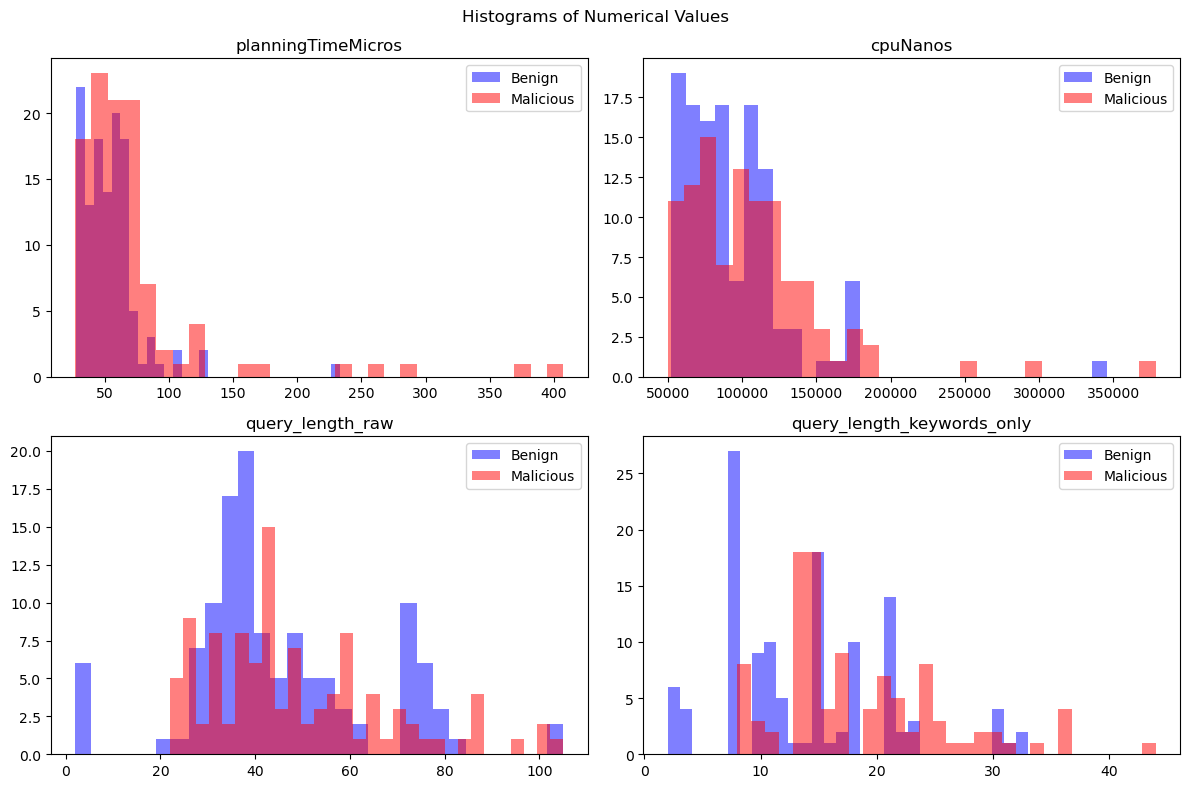

In [29]:
n_cols = 2 
n_rows = math.ceil(len(numerical_columns) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
sns.set_palette(["blue", "red"])

fig.suptitle("Histograms of Numerical Values")

for i, var in enumerate(numerical_columns):
    axs[i // n_cols, i % n_cols].hist(sample_0[[var]], bins=30, alpha=0.5, label='Benign', color='blue')
    axs[i // n_cols, i % n_cols].hist(sample_1[[var]], bins=30, alpha=0.5, label='Malicious', color='red')
    axs[i // n_cols, i % n_cols].legend(loc='upper right')
    axs[i // n_cols, i % n_cols].set_title(var)

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

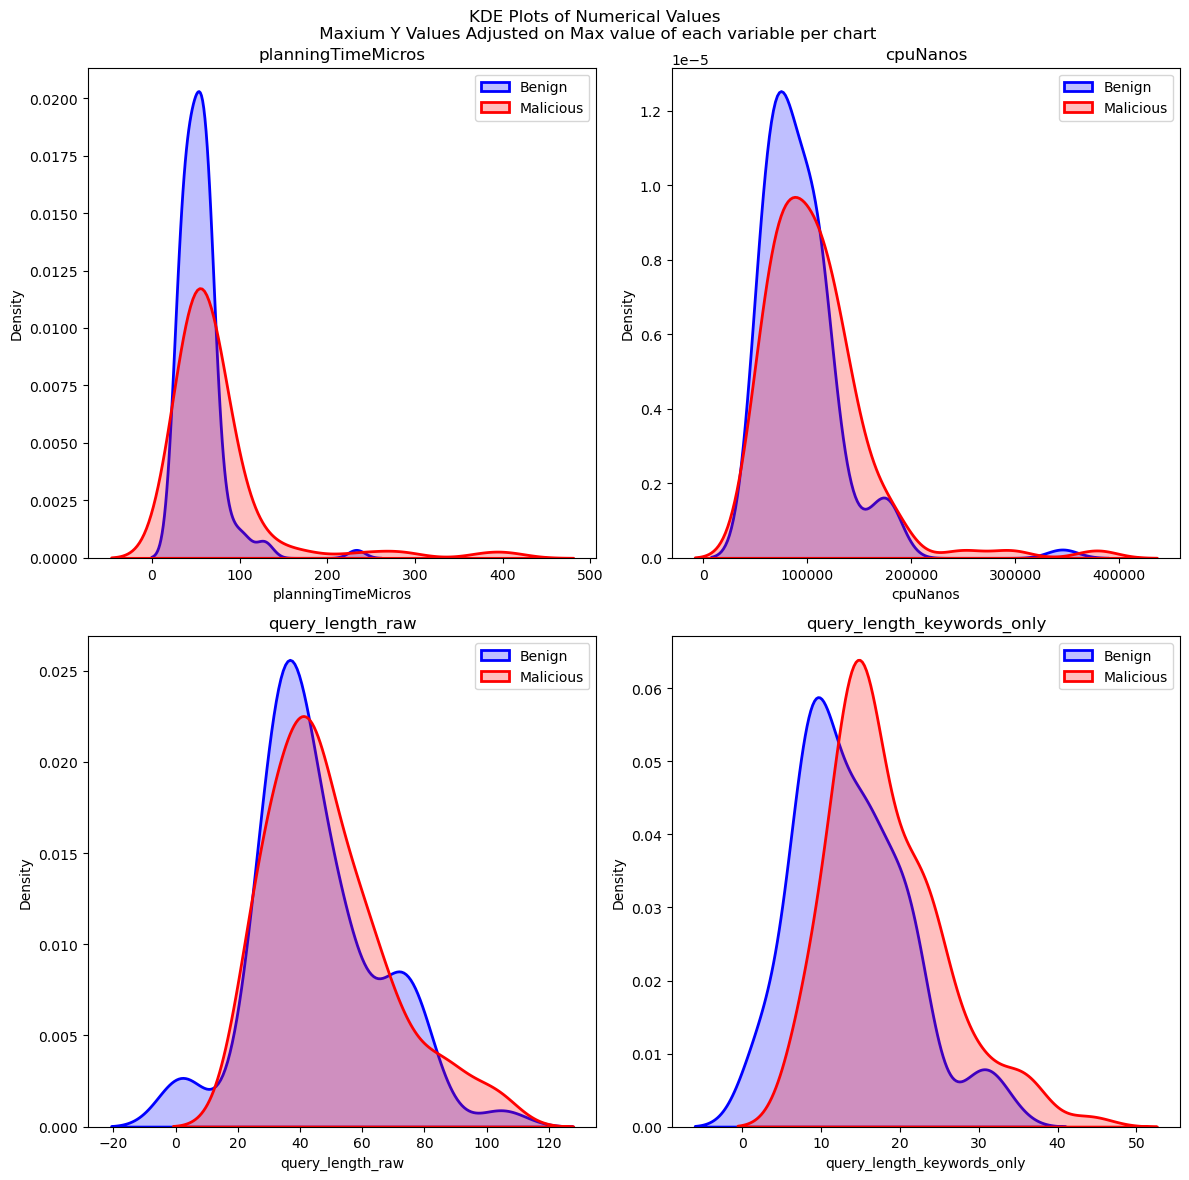

In [12]:
n_cols = 2
n_rows = math.ceil(len(numerical_columns) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))
sns.set_palette(["blue", "red"])

fig.suptitle("KDE Plots of Numerical Values\n Maxium Y Values Adjusted on Max value of each variable per chart")

for i, var in enumerate(numerical_columns):
    sns.kdeplot(sample_0[var], ax=axs[i//n_cols, i%n_cols], label='Benign', linewidth=2, fill=True)
    sns.kdeplot(sample_1[var], ax=axs[i//n_cols, i%n_cols], label='Malicious', linewidth=2, fill=True)
    axs[i//n_cols, i%n_cols].legend(loc='upper right')
    axs[i//n_cols, i%n_cols].set_title(var)

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

In [13]:
from scipy.stats import mannwhitneyu
import pandas as pd

stats = []
p_values = []
significant_0_1 = []
significant_0_05 = []
significant_0_01 = []

for col in numerical_columns:
    stat, p_value = mannwhitneyu(sample_0[col], sample_1[col])
    stats.append(stat)
    p_values.append(p_value)
    significant_0_1.append(p_value < 0.1)
    significant_0_05.append(p_value < 0.05)
    significant_0_01.append(p_value < 0.01)

mu_results = pd.DataFrame({
    'Column': numerical_columns,
    'Statistic': stats,
    'P-value': p_values,
    'Significant 0.1': significant_0_1,
    'Significant 0.05': significant_0_05,
    'Significant 0.01': significant_0_01
})

print("Mann-Whitney U test:")
mu_results

Mann-Whitney U test:


,Column,Statistic,P-value,Significant 0.1,Significant 0.05,Significant 0.01
0,planningTimeMicros,4926.5,0.006628,True,True,True
1,cpuNanos,5013.0,0.011228,True,True,False
2,query_length_raw,5589.0,0.178336,False,False,False
3,query_length_keywords_only,3997.0,0.000003,True,True,True


In [14]:
significant_numerical_columns = mu_results[mu_results['Significant 0.01'] == True]
significant_numerical_columns = significant_numerical_columns['Column'].tolist()
significant_numerical_columns

['planningTimeMicros', 'query_length_keywords_only']

Binary Data Analysis

In [15]:
x_boolean_columns

['$eq',
 '$gt',
 '$in',
 '$ne',
 '$nin',
 '$type',
 '$mod',
 '$regex',
 '$where',
 '$elemMatch',
 '$size',
 '$',
 '>=',
 '<=',
 '<',
 '>',
 'selector_comparision',
 'selector_logical',
 'selector_element',
 'selector_evalutaion',
 'selector_array',
 'selector_bitwise',
 'projection',
 'misc',
 'selector',
 'standard_logical',
 'all_operators',
 'null_operand',
 'regex_null_operand']

In [16]:

from scipy.stats import chi2_contingency
import numpy as np

# Prepare a list to store results
phi_results = []
# Iterate over boolean columns
for col in x_boolean_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(merged_optimized_data[col], merged_optimized_data['label'])
    # Compute chi-square statistic, p-value, degrees of freedom, and expected frequencies
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    # Compute phi coefficient
    phi_coefficient = np.sqrt(chi2_stat / len(merged_optimized_data))
    # Append results to the list
    phi_results.append({'Column': col, 'Phi Coefficient': phi_coefficient, 'P-value': p_val, 'Significant 0.1': p_val < 0.1, 'Significant 0.05': p_val < 0.05, 'Significant 0.01': p_val < 0.01})

# Convert the list to a DataFrame
phi_results_df = pd.DataFrame(phi_results)
phi_results_df

,Column,Phi Coefficient,P-value,Significant 0.1,Significant 0.05,Significant 0.01
0,$eq,0.086135,0.197345,False,False,False
1,$gt,0.055968,0.402223,False,False,False
2,$in,0.070561,0.290941,False,False,False
3,$ne,0.172719,0.009737,True,True,True
4,$nin,0.004795,0.942783,False,False,False
5,$type,0.095043,0.154889,False,False,False
6,$mod,0.004795,0.942783,False,False,False
7,$regex,0.080065,0.230798,False,False,False
8,$where,0.111045,0.096519,True,False,False
9,$elemMatch,0.111045,0.096519,True,False,False


In [17]:
significant_boolean_columns = phi_results_df[phi_results_df['Significant 0.01'] == True]
significant_boolean_columns = significant_boolean_columns['Column'].tolist()
significant_boolean_columns

['$ne', '$']

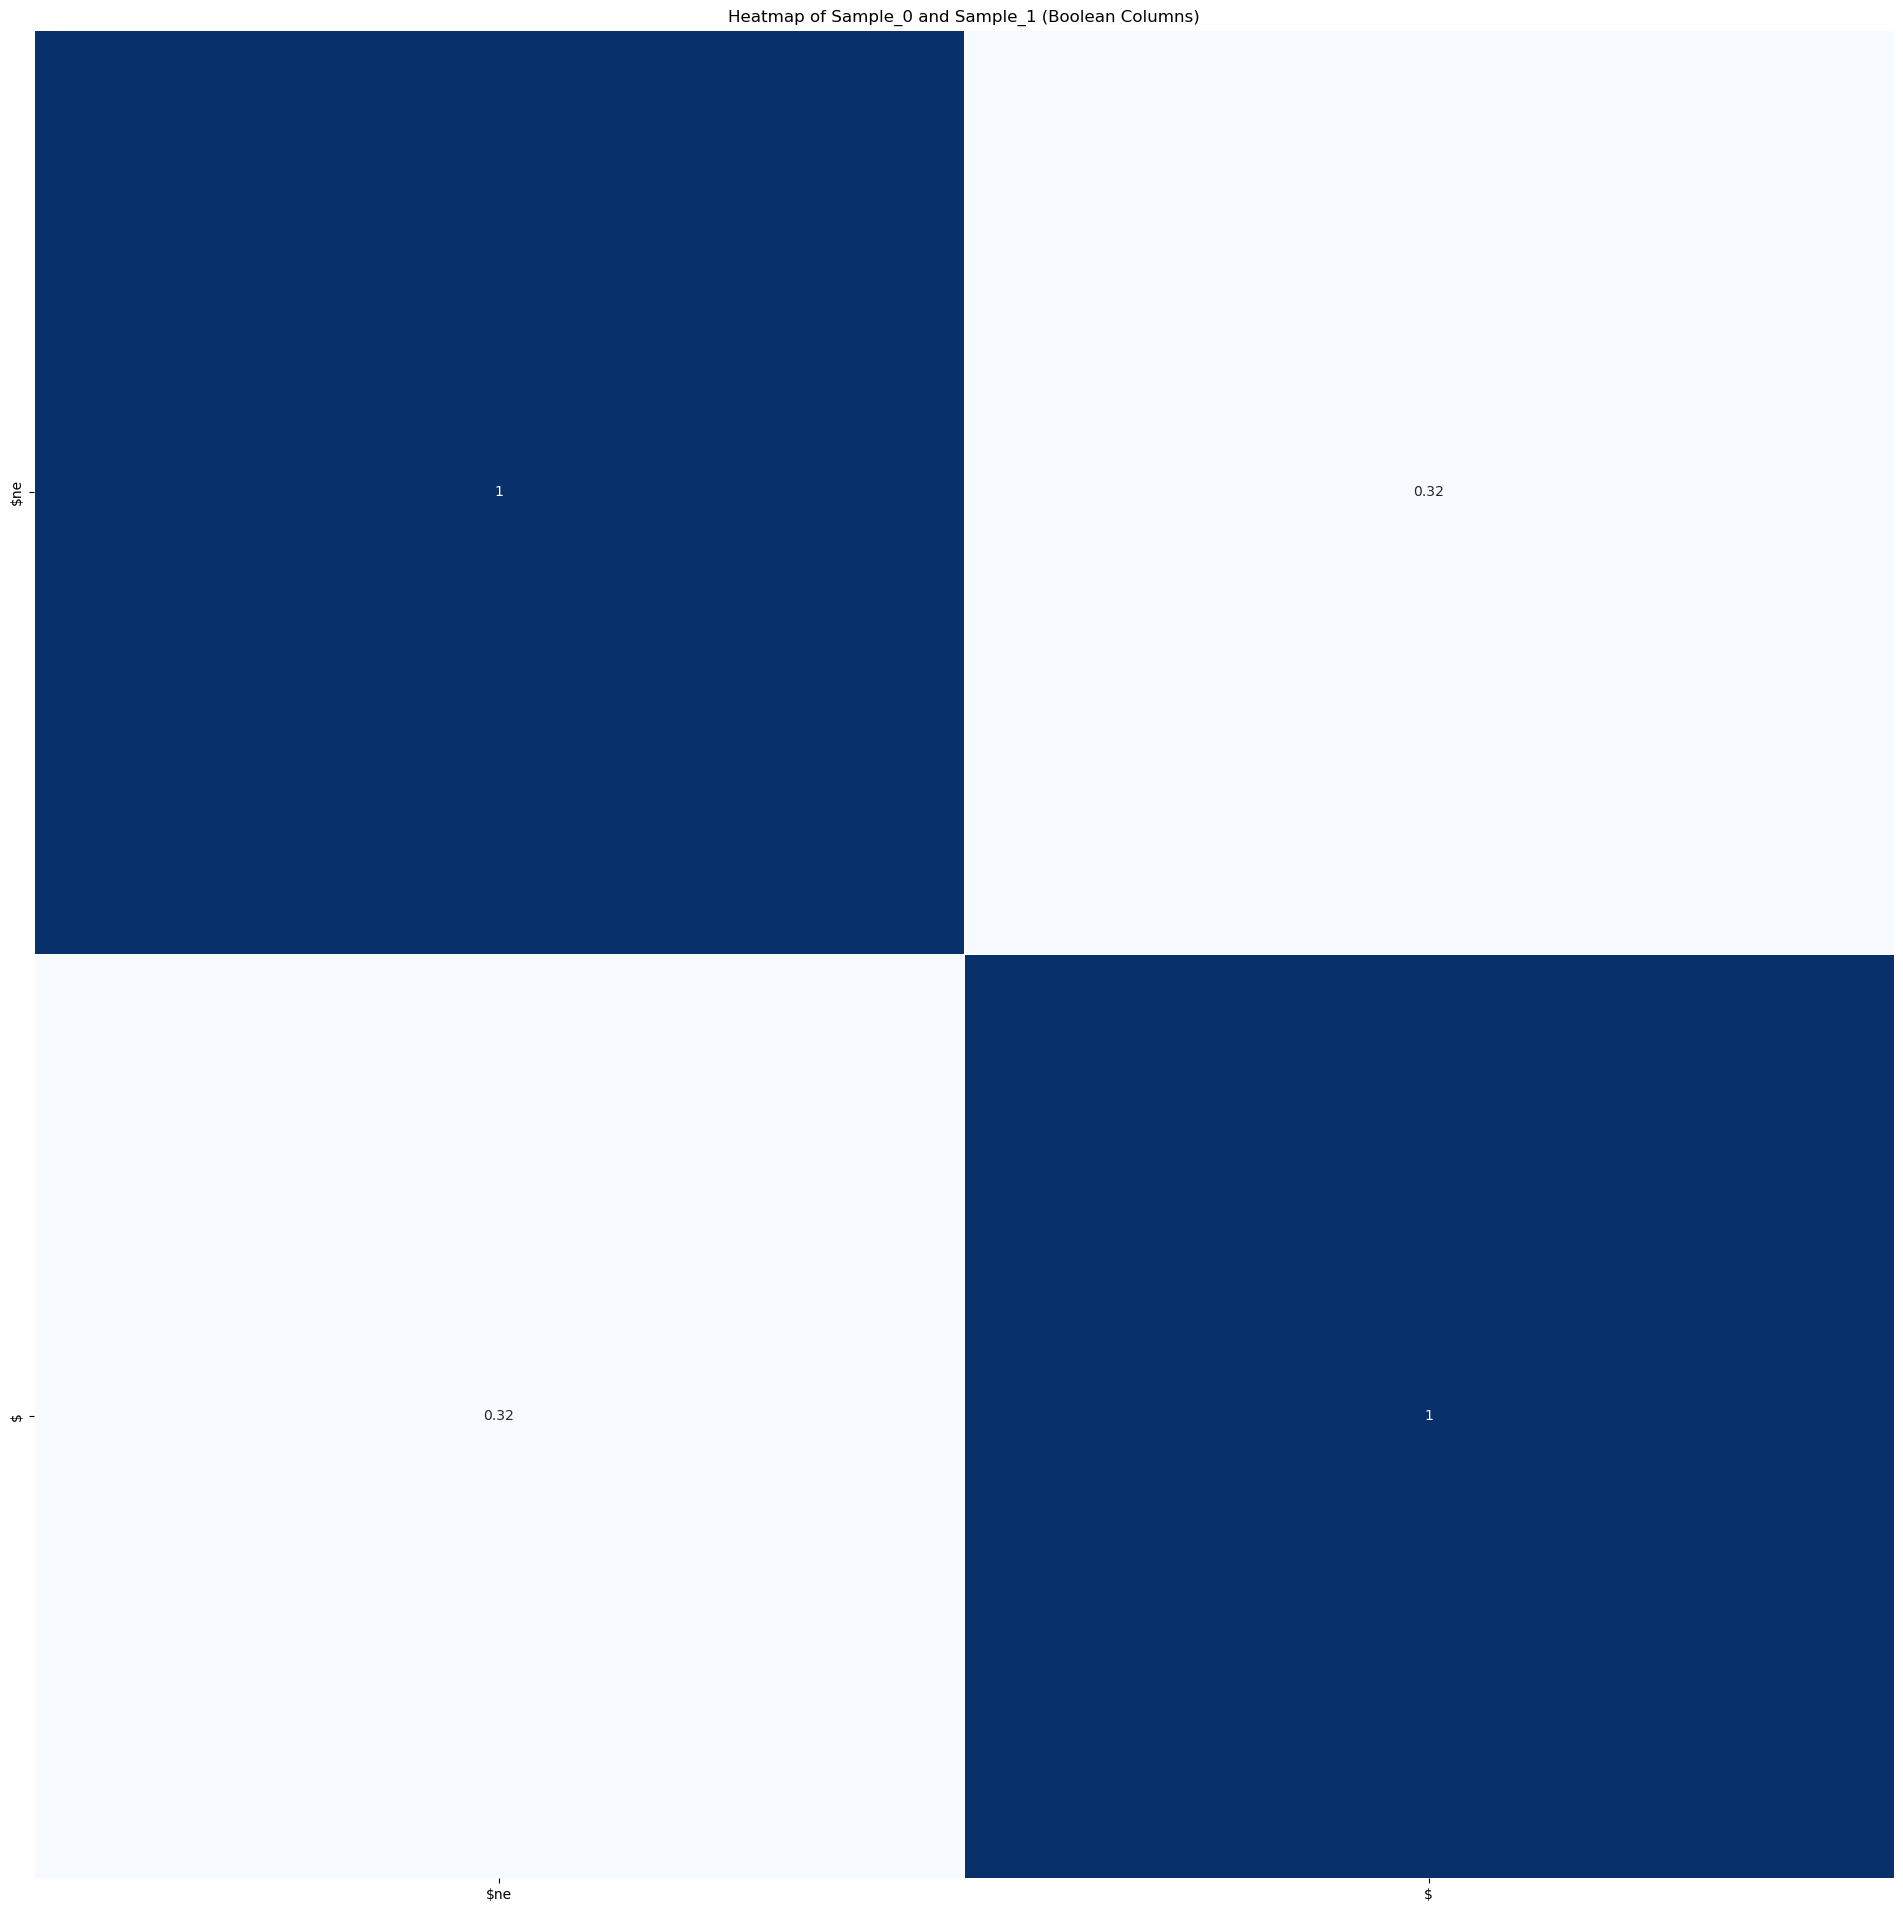

In [18]:
plt.figure(figsize=(24, 24))  # Set figure size
sns.heatmap(merged_optimized_data[significant_boolean_columns].corr(), cmap='Blues', annot=True, cbar=False, linewidths=0.5)
plt.title('Heatmap of Sample_0 and Sample_1 (Boolean Columns)')
plt.show()

In [19]:
# Combine the two lists and remove duplicates by converting them to sets
significant_columns = list(set(significant_numerical_columns) | set(significant_boolean_columns))
significant_columns

['query_length_keywords_only', 'planningTimeMicros', '$', '$ne']

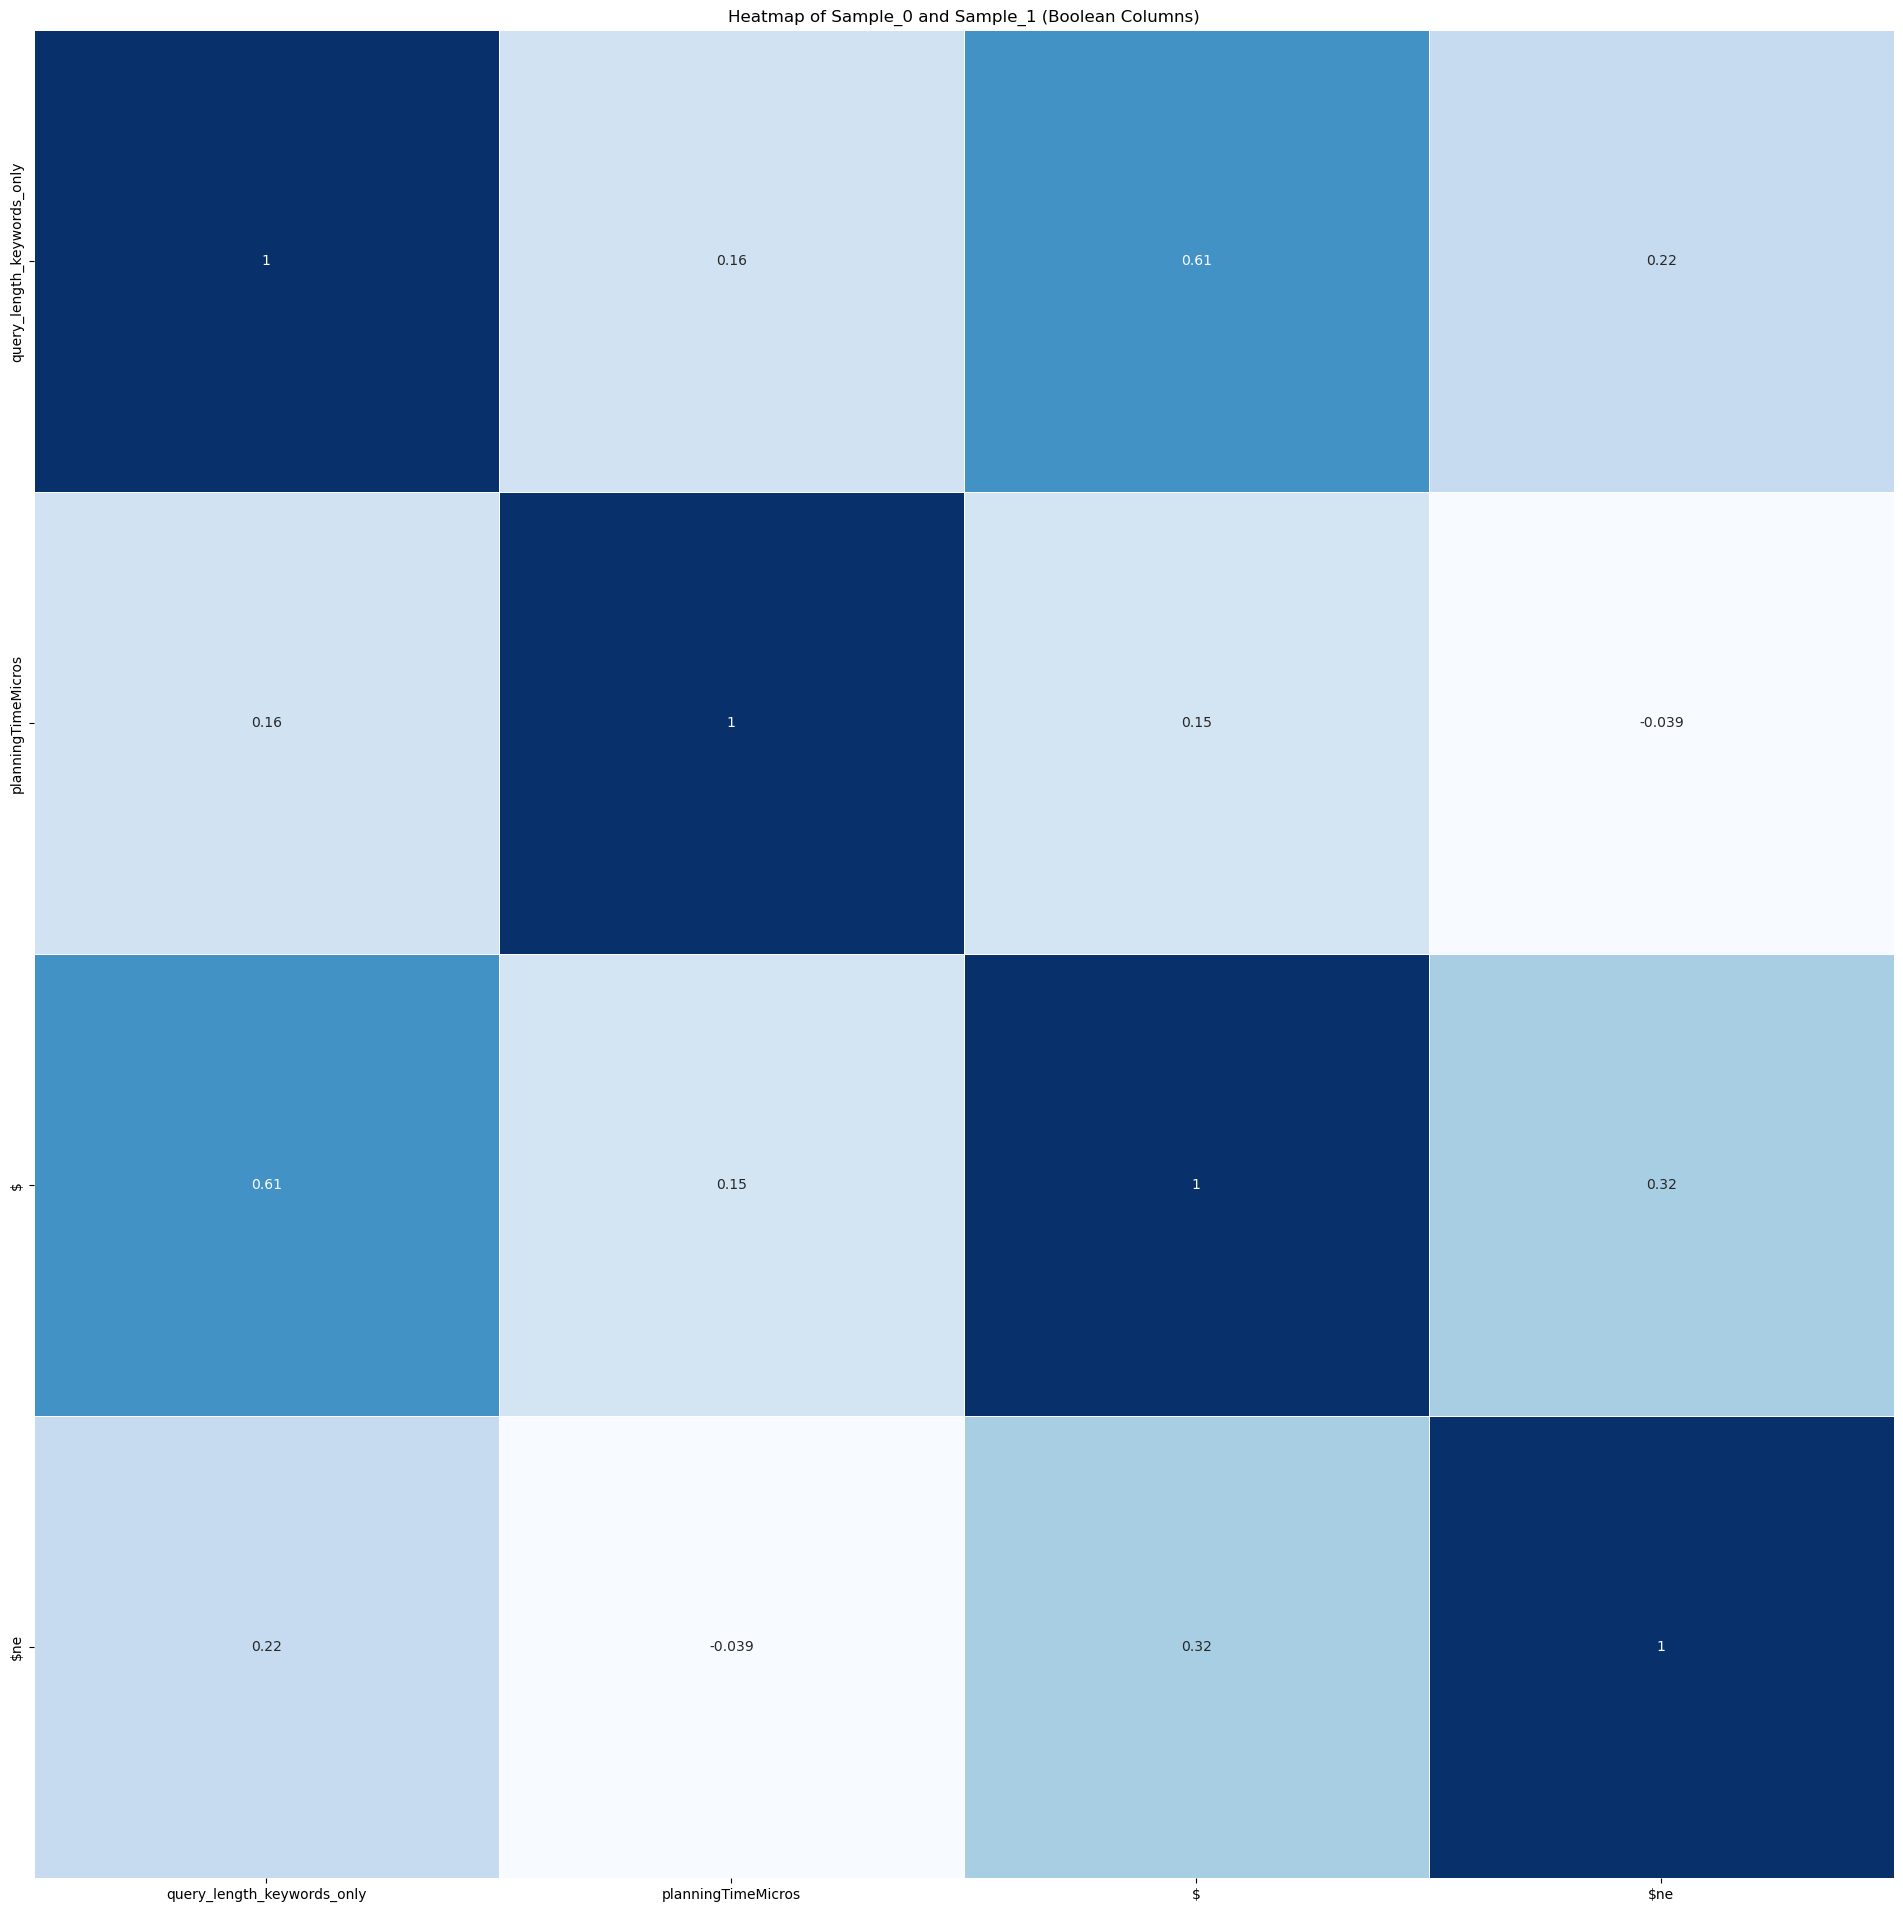

In [20]:
plt.figure(figsize=(24, 24))  # Set figure size
sns.heatmap(merged_optimized_data[significant_columns].corr(), cmap='Blues', annot=True, cbar=False, linewidths=0.5)
plt.title('Heatmap of Sample_0 and Sample_1 (Boolean Columns)')
plt.show()

In [21]:
significant_data = merged_optimized_data[significant_columns]
significant_data.head()

,query_length_keywords_only,planningTimeMicros,$,$ne
0,12,83.0,False,False
1,12,83.0,False,False
2,17,71.0,True,False
3,17,71.0,True,False
4,13,42.0,True,True


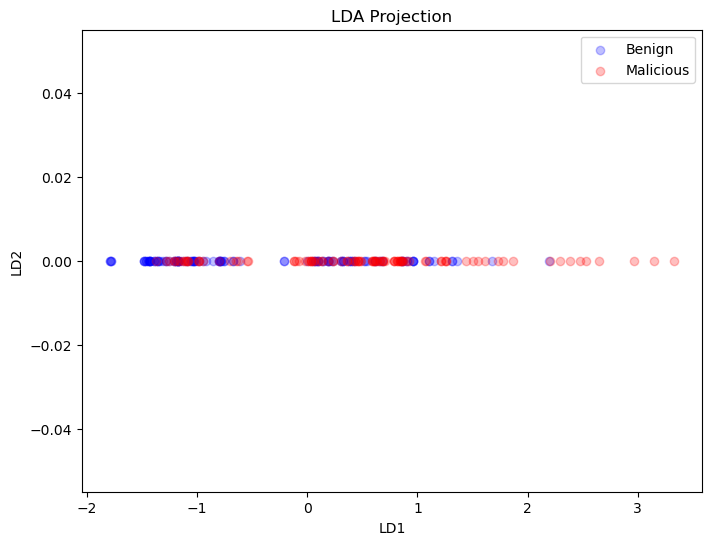

Explained Variance Ratio (LDA): [1.]
LDA Components:
[[0.05088343]
 [0.00883541]
 [1.1049157 ]
 [0.79246699]]


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt

# Separate features and target variable
X = merged_optimized_data[significant_columns]
y = merged_optimized_data[['label']]
y = y.values.flatten()

# Standardize floating-point feature
scaler = StandardScaler()
lda = LinearDiscriminantAnalysis(n_components=min(X.shape[1], len(np.unique(y)) - 1))
X_lda = lda.fit_transform(X, y)

# Plot LDA
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['b', 'r']  # Assuming binary target classes
for target, color in zip(targets, colors):
    class_label = 'Benign' if target == 0 else 'Malicious'
    plt.scatter(X_lda[y == target], np.zeros_like(X_lda[y == target]), c=color, label=class_label, alpha=0.25)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA Projection')
plt.legend()
plt.show()

# Return LDA results
print("Explained Variance Ratio (LDA):", lda.explained_variance_ratio_)

lda_components = lda.scalings_

print("LDA Components:")
print(lda_components)


Principal Component Labels:
Component 1: $, query_length_keywords_only, $ne
Component 2: planningTimeMicros, query_length_keywords_only, $


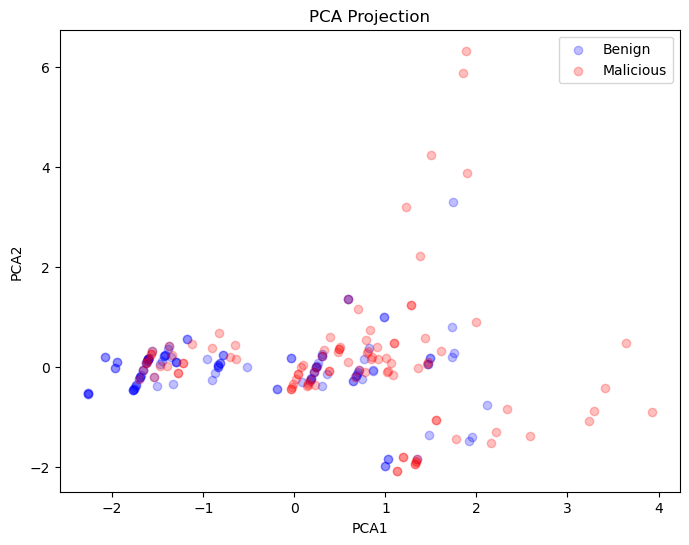

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get original feature names
feature_names = X.columns

# Get principal component loadings
component_loadings = pd.DataFrame(pca.components_, columns=feature_names)

# Label principal components based on loadings
component_labels = []
for i in range(len(component_loadings)):
    top_features = component_loadings.iloc[i].sort_values(ascending=False).index[:3]  # Top 3 features with highest loading
    component_labels.append(', '.join(top_features))

# Print component labels
print("Principal Component Labels:")
for i, label in enumerate(component_labels):
    print(f"Component {i+1}: {label}")

# Plot PCA with component names
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['b', 'r']  # Assuming binary target classes

for target, color in zip(targets, colors):
    class_label = 'Benign' if target == 0 else 'Malicious'
    plt.scatter(X_pca[y == target, 0], X_pca[y == target, 1], c=color, label=class_label, alpha=0.25)  # Set alpha to 0.5 for transparency

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Projection')
plt.legend()

plt.show()


t-SNE Transformed Coordinates:
[[ 35.204666    -1.8281844 ]
 [ 37.42965     -1.0355814 ]
 [ 24.91523     -0.3308145 ]
 [ 24.91523     -0.3308145 ]
 [-25.12896     -5.511315  ]
 [-25.12896     -5.511315  ]
 [-18.473228    -9.763822  ]
 [-17.868423    -7.481945  ]
 [ 34.54698      0.97528476]
 [ 34.54698      0.97528476]
 [-20.845434    -7.500013  ]
 [-20.845434    -7.500013  ]
 [ 15.061335   -18.241468  ]
 [ 15.061335   -18.241468  ]
 [ 45.863953     9.802262  ]
 [ 45.863953     9.802262  ]
 [ 45.863953     9.802262  ]
 [-29.823378    -8.3846035 ]
 [-27.611637    -7.475919  ]
 [-45.887615     6.558911  ]
 [-47.70264      7.8625174 ]
 [-51.10947      7.625983  ]
 [-51.10947      7.625983  ]
 [-51.666138     4.8455906 ]
 [ 17.518084   -23.19021   ]
 [ 17.518084   -23.19021   ]
 [-15.179893    -5.342131  ]
 [-14.699848    -7.651102  ]
 [ -2.8885264   10.1748495 ]
 [ -1.7988672   12.175453  ]
 [-55.16711      4.942336  ]
 [-55.16711      4.942336  ]
 [-48.95533      4.53464   ]
 [-48.95533 

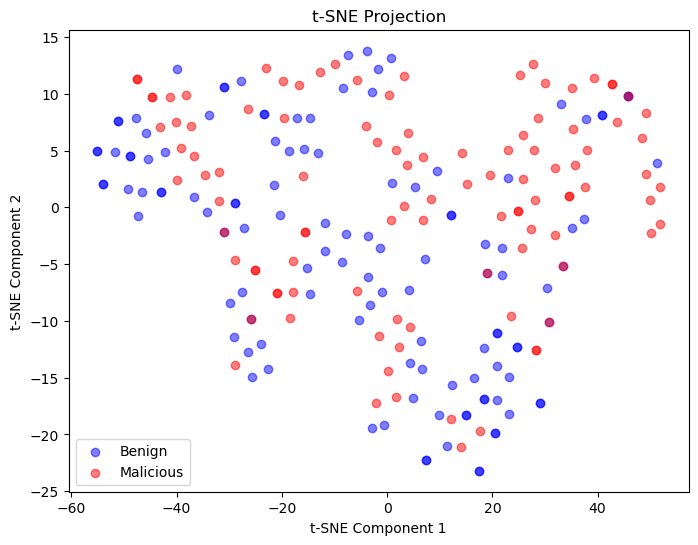

Total Number of Points: 224
Number of Overlapping Points: 7
% Ambiguous Points: 3.125
% Max Accuracy: 96.875


In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Print out the t-SNE transformed coordinates
print("t-SNE Transformed Coordinates:")
print(X_tsne)

# Plot the reduced-dimensional data
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['b', 'r']  # Assuming binary target classes

# Initialize lists to store point coordinates for each class
class_0_points = []
class_1_points = []

for target, color in zip(targets, colors):
    class_label = 'Benign' if target == 0 else 'Malicious'
    plt.scatter(X_tsne[y == target, 0], X_tsne[y == target, 1], c=color, label=class_label, alpha=0.5)

    # Store point coordinates for each class
    class_points = list(zip(X_tsne[y == target, 0], X_tsne[y == target, 1]))
    if target == 0:
        class_0_points.extend(class_points)
    else:
        class_1_points.extend(class_points)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection')
plt.legend()
plt.show()

# Calculate the total number of points
total_points = len(class_0_points) + len(class_1_points)
print(f"Total Number of Points: {total_points}")

# Calculate the number of overlapping points
overlapping_points = 0
for point_0 in class_0_points:
    for point_1 in class_1_points:
        if point_0 == point_1:
            overlapping_points += 1

print(f"Number of Overlapping Points: {overlapping_points}")

percentageA = overlapping_points/total_points
print(f"% Ambiguous Points: {percentageA*100}")
print(f"% Max Accuracy: {(1 - percentageA)*100}")

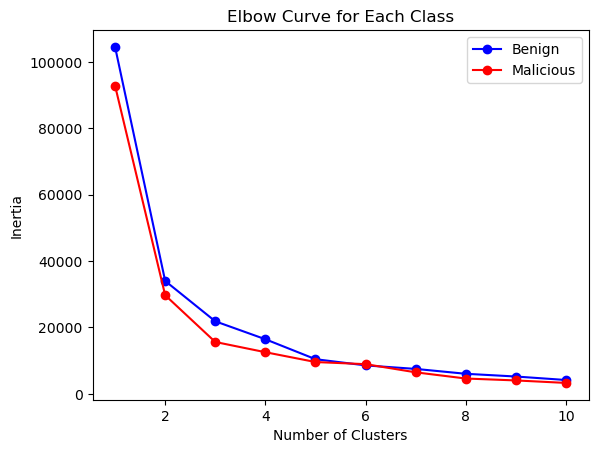

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Define the range of clusters to try
num_clusters_range = range(1, 11)  # Try cluster numbers from 1 to 10

# Plot the elbow curve
for target_class in np.unique(y):
    X_class = X_tsne[y == target_class]
    inertia_values = []
    for num_clusters in num_clusters_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(X_class)
        inertia_values.append(kmeans.inertia_)
    class_name = 'Benign' if target_class == False else 'Malicious'
    plt.plot(num_clusters_range, inertia_values, marker='o', label=f'{class_name}')

# Add labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve for Each Class')
plt.legend()

# Show plot
plt.show()



Total Overlap Area: 169.57766871637668
Total Area: 1252.7405392567016
Overlap Percentage: 13.54%
Estimated Accuracy: 86.46%

Cluster Counts per Class:
Class 0 (Benign): 13 clusters
Class 1 (Malicious): 15 clusters

Grand Total of Clusters: 28


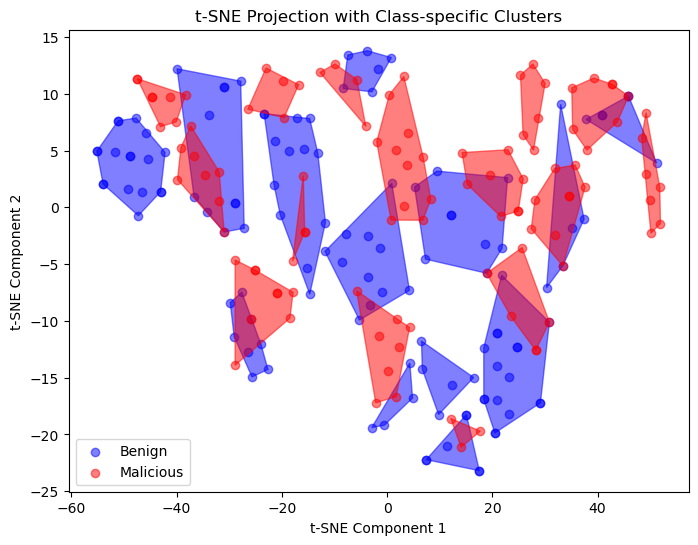

In [26]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.ops import unary_union
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Define the number of clusters for each class
class_0_clusters = 13
class_1_clusters = 15

# Initialize a figure
plt.figure(figsize=(8, 6))

# Define colors for each class
class_colors = {0: 'blue', 1: 'red'}

# Initialize lists to store polygons for each class
class_0_polygons = []
class_1_polygons = []

# Iterate over unique classes
for target_class in np.unique(y):
    # Filter the data points for the current class
    X_class = X_tsne[y == target_class]

    # Apply K-means clustering within the current class
    kmeans = KMeans(n_clusters=class_0_clusters if target_class == 0 else class_1_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_class)

    # Plot the data points within the current class
    class_label = 'Benign' if target_class == 0 else 'Malicious'
    plt.scatter(X_class[:, 0], X_class[:, 1], label=class_label, color=class_colors[target_class], alpha=0.5)

    # Plot the polygons for each cluster and store them in the corresponding list
    for cluster in range(kmeans.n_clusters):
        cluster_points = X_class[clusters == cluster]
        if len(cluster_points) < 3:
            continue  # A valid polygon cannot be formed with less than 3 points
        hull = ConvexHull(cluster_points)
        polygon = Polygon(cluster_points[hull.vertices], fill=True, edgecolor=class_colors[target_class],
                          facecolor=class_colors[target_class], alpha=0.5)
        plt.gca().add_patch(polygon)
        if target_class == 0:
            class_0_polygons.append(ShapelyPolygon(cluster_points[hull.vertices]))
        else:
            class_1_polygons.append(ShapelyPolygon(cluster_points[hull.vertices]))

# Calculate the union of polygons for each class
union_0 = unary_union(class_0_polygons)
union_1 = unary_union(class_1_polygons)

# Calculate the total overlap area
intersection = union_0.intersection(union_1)
total_overlap_area = intersection.area

# Calculate the total area covered by all the polygons
total_area = union_0.area + union_1.area - total_overlap_area

# Calculate the overlap percentage
overlap_percentage = (total_overlap_area / total_area) * 100
estimated_accuracy = 100 - overlap_percentage

# Print results
print("Total Overlap Area:", total_overlap_area)
print("Total Area:", total_area)
print("Overlap Percentage: {:.2f}%".format(overlap_percentage))
print("Estimated Accuracy: {:.2f}%".format(estimated_accuracy))

# Print cluster counts per class
print("\nCluster Counts per Class:")
print(f"Class 0 (Benign): {class_0_clusters} clusters")
print(f"Class 1 (Malicious): {class_1_clusters} clusters")

# Calculate the grand total of clusters
grand_total_clusters = class_0_clusters + class_1_clusters
print(f"\nGrand Total of Clusters: {grand_total_clusters}")

# Set plot labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection with Class-specific Clusters')
plt.legend()

# Show plot
plt.show()



In [27]:
final_significant_columns = significant_columns + ['label']
significant_data = merged_optimized_data[final_significant_columns]
significant_data.head()

,query_length_keywords_only,planningTimeMicros,$,$ne,label
0,12,83.0,False,False,False
1,12,83.0,False,False,False
2,17,71.0,True,False,True
3,17,71.0,True,False,True
4,13,42.0,True,True,True


In [28]:
significant_data.to_csv("../Dataset/explored_dataset.csv")